In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from data_collection import *
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

# Cleaning and Setup

In [2]:
date = pd.to_datetime('2020/09/09')

assets = pd.read_csv('Notes&Bonds_raw.csv')
assets.MATURITY = pd.to_datetime(assets.MATURITY)

# Keep only bonds mature at June or Dec, before 2028
# Keep May and Nov in 2028 as 2028 does not have
assets = assets[(((assets.MATURITY.dt.month % 6 == 0)) & (assets.MATURITY.dt.year < 2028))
                | ((assets.MATURITY.dt.year == 2028) & (assets.MATURITY.dt.month == 5))]

print("Number of bond assets: ", len(assets))

# Use mean of BID and ASK as prices
assets['PRICE'] = (assets.BID + assets.ASKED) / 2
assets = assets[['MATURITY', 'COUPON', 'PRICE']]
print('Q2 Assets:')
portfolio = assets.copy() # for q3
portfolio.reset_index(drop=True, inplace=True)
display(portfolio)

# Calculate accrual interest and full price
nextdate = pd.to_datetime(assets.MATURITY.apply(lambda x : str(2020) + '-' + x.strftime('%m-%d')
                               if x.month > date.month else
                               str(2020) + '-' + (x+relativedelta(months=6)).strftime('%m-%d')))
accrual = nextdate.apply(lambda x: (x - date) / ((x+relativedelta(months=6)) - x))
assets['PRICE'] = accrual*assets.COUPON/2 + assets.PRICE
assets.MATURITY = assets.MATURITY.dt.strftime('%Y%m')


# Hard code May 2028 and Nov 2028 as June and Dec
assets.loc[assets.MATURITY == '202805', 'MATURITY'] = '202806'

# Mapping year-month to period 0 to 16
# 0: 202006, 1: 202012, ... 16: 202806
dates = [str(y) + m for y in list(range(2020,2029)) for m in ['06', '12']]
period = list(range(len(dates)))
datemap = dict(zip(dates, period))

assets.MATURITY = assets.MATURITY.map(datemap)

print('assets:')
display(assets)

def transform(x):
    cashflow = [0] * 16
    for i in range(x.MATURITY.astype('int')):
        if i != x.MATURITY.astype('int') - 1:
            cashflow[i] = x.COUPON / 2
        else:
            cashflow[i] = 100 + x.COUPON / 2
    return pd.Series(cashflow, index=list(range(1,17)))

n = 34 # number of assets
m = 16 # number of payment periods

# Construct bond payoff matrix (F matrix)
F = assets.apply(lambda x: transform(x), axis=1)
print('Bond payoff matrix:')
display(F)
F = F.values.T

# Liabilities
L = np.array([11, 9, 7, 9, 9, 12, 6, 8, 
     10,  5, 7, 7, 8,  7, 9,  9,])

R = -np.identity(m)
R[1:m,0:m-1] = R[1:m,0:m-1]+np.identity(m-1)

p = np.array(assets.PRICE)

Number of bond assets:  34
Q2 Assets:


,MATURITY,COUPON,PRICE
0,2020-12-15,1.875,100.154
1,2020-12-31,1.750,100.159
2,2020-12-31,2.375,100.219
3,2020-12-31,2.500,100.232
4,2021-06-15,2.625,101.289
5,2021-06-30,1.125,100.254
6,2021-06-30,1.625,101.064
7,2021-06-30,2.125,101.192
8,2021-12-15,2.625,103.044
9,2021-12-31,1.625,101.299


assets:


,MATURITY,COUPON,PRICE
13,1,1.875,100.653657
14,1,1.750,100.705271
15,1,2.375,100.960367
16,1,2.500,101.012387
39,2,2.625,101.988519
40,2,1.125,100.600154
41,2,1.625,101.564000
42,2,2.125,101.845846
67,3,2.625,103.743519
68,3,1.625,101.806251


Bond payoff matrix:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
13,100.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
14,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
15,101.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,101.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
39,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
40,0.5625,100.5625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
41,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
42,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
67,1.3125,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.8125,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# Q3

In [3]:
# cvxpy problem setup and solution
x = cp.Variable(n)
s = cp.Variable(m)
prob = cp.Problem(cp.Minimize(p.T@x),
                 [F@x + R@s == L, x>=0, s>=0])
prob.solve() 

# Recall that cvxpy yields shadow prices with flipped sign
shadowprices = -prob.constraints[0].dual_value
impliedrates = 1/(shadowprices**(1/liab_stream.index))-1

# Print result.
print("\nThe optimal cost of portfolio", prob.value)
print("\nPortfolio x:")
# print(x.value)
# For better presentation
for i in x.value:
	print("{:.3f}".format(i))
print("\nSurplus s:")
print(s.value)
print("\nImplied rates:")
print(impliedrates)


The optimal cost of portfolio 130.79092571626276

Portfolio x:
0.102
0.000
0.000
0.000
0.148
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.340
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.075
0.000
0.000
0.096
0.114
0.000
0.000
0.067
0.078
0.157
0.089

Surplus s:
[ 8.42928838e-08  6.49336518e+00  1.04938247e-07  2.55439240e+01
  1.70292816e+01  5.51463951e+00  1.20509917e-07  5.95053975e-05
  3.98982226e-08  6.70241324e+00  6.20709970e-08  1.13568809e-07
  4.58748408e-08  8.87245843e+00  1.70117675e-08 -7.22174976e-10]

Implied rates:
Float64Index([ 0.009701727181299802,  0.007945728133050611,
                0.00486250023482615,  0.005064516709211819,
               0.003957348021192519,  0.003247419725437961,
               0.002753462333568546,   0.00303543368255621,
               0.002687315069021645,  0.003952579134762324,
              0.0035784396745575098,  0.004083395801429912,
                0.00417292758595833,  0.004829052833020597,
               0.004497

In [4]:
portfolio['POSITION'] = x.value.round(3)
display(portfolio)

,MATURITY,COUPON,PRICE,POSITION
0,2020-12-15,1.875,100.154,0.102
1,2020-12-31,1.750,100.159,0.000
2,2020-12-31,2.375,100.219,0.000
3,2020-12-31,2.500,100.232,0.000
4,2021-06-15,2.625,101.289,0.148
5,2021-06-30,1.125,100.254,0.000
6,2021-06-30,1.625,101.064,0.000
7,2021-06-30,2.125,101.192,0.000
8,2021-12-15,2.625,103.044,0.000
9,2021-12-31,1.625,101.299,0.000


# Q4

In [5]:
terms = pd.date_range(start='12/1/2020', end='12/1/2028', freq='6M')
display(pd.Series(impliedrates, terms, name='Implied Rate').to_frame())

,Implied Rate
2020-12-31,0.009702
2021-06-30,0.007946
2021-12-31,0.004863
2022-06-30,0.005065
2022-12-31,0.003957
2023-06-30,0.003247
2023-12-31,0.002753
2024-06-30,0.003035
2024-12-31,0.002687
2025-06-30,0.003953


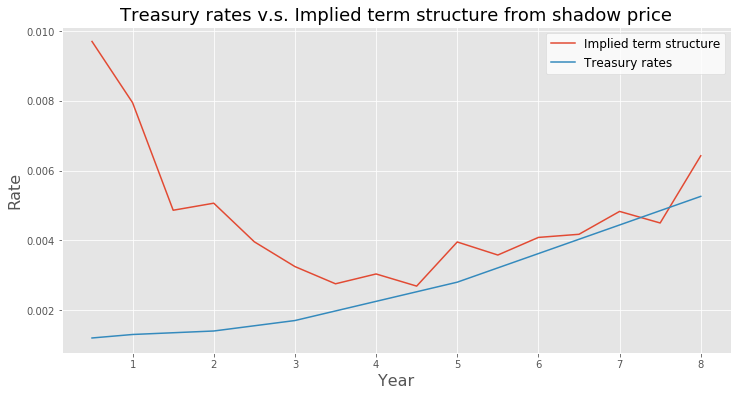

In [6]:
print(' ')
plt.figure(figsize=[12,6])
pd.Series(impliedrates, index=0.5 * np.array(range(1, 17)), name='Implied term structure').plot()
pd.Series(term_struct_interp(np.array(range(1,17)) * 0.5), index=0.5 * np.array(range(1, 17)), name='Treasury rates').plot()
plt.title("Treasury rates v.s. Implied term structure from shadow price", size=18)
plt.legend(fontsize=12, facecolor='white')
plt.ylabel('Rate', size=16)
plt.xlabel('Year', size=16)
plt.show()

# Q5

In [7]:
corporate = pd.read_csv('Corporate_raw.csv').iloc[:,1:]
corporate.MATURITY = pd.to_datetime(corporate.MATURITY)
# Calculate accrual interest and full price
nextdate = pd.to_datetime(corporate.MATURITY.apply(lambda x : str(2020) + '-' + x.strftime('%m-%d')
                               if x.month > date.month else
                               str(2020) + '-' + (x+relativedelta(months=6)).strftime('%m-%d')))
accrual = nextdate.apply(lambda x: (x - date) / ((x+relativedelta(months=6)) - x))
corporate['PRICE'] = accrual*corporate.COUPON/2 + corporate.PRICE

display(corporate[corporate.MATURITY <= '20290101'].reset_index(drop=True))
portfolio_corporate = corporate[corporate.MATURITY <= '20290101'].reset_index(drop=True).copy()

corporate.MATURITY = corporate.MATURITY.apply(lambda x: x.strftime('%Y') + '06'
                                              if x.month < 6
                                              else x.strftime('%Y') + '12')

corporate.MATURITY = corporate.MATURITY.map(datemap)
corporate.dropna(inplace=True)
#display(corporate.reset_index(drop=True))

,PRICE,COUPON,MATURITY
0,105.172624,2.650,2022-11-03
1,128.295608,6.730,2023-11-15
2,100.511119,2.125,2020-11-01
3,104.803232,2.800,2022-05-15
4,100.100846,0.625,2025-07-15


In [8]:
c_present = pd.read_csv('Corporate_raw.csv', index_col = 0)
c_present

,PRICE,COUPON,MATURITY
MICROSOFT 15/22,104.7700,2.650,2022/11/3
MICROSOFT 09/39,145.1900,5.200,2039/6/1
MICROSOFT 11/41,149.5100,5.300,2041/2/8
JOHNSON + JOHNSON 03/33,110.3400,4.950,2033/5/15
JOHNSON + JOHNSON 2023,127.0500,6.730,2023/11/15
INTERNATIONAL BANK FOR REC &DEV,100.2000,2.125,2020/11/1
PRIVATE EXPT FDG CORP,104.2850,2.800,2022/5/15
INTER-AMERICAN DEV BK,100.5095,0.625,2025/7/15


In [9]:
# Filter out bonds with maturity after 2028 as we have no cashflow needs after that
# Hard code the newly added corporate bond
# 202211: 5
# 202311: 7
assets2 = assets.copy()
assets2 = assets2.append(corporate)
print('asset2:')
portfolio2 = assets2.copy() # for q3
portfolio2.reset_index(drop=True, inplace=True)
display(portfolio2)

def transform(x):
    cashflow = [0] * 16
    for i in range(x.MATURITY.astype('int')):
        if i != x.MATURITY.astype('int') - 1:
            cashflow[i] = x.COUPON / 2
        else:
            cashflow[i] = 100 + x.COUPON / 2
    return pd.Series(cashflow, index=list(range(1,17)))

n = 34 + 5 # number of assets
m = 16 # number of payment periods

# Construct bond payoff matrix (F matrix)
F = assets2.apply(lambda x: transform(x), axis=1)
print('Bond payoff matrix:')
display(F)
F = F.values.T

# Liabilities
L = np.array([11, 9, 7, 9, 9, 12, 6, 8, 
     10,  5, 7, 7, 8,  7, 9,  9,])

R = -np.identity(m)
R[1:m,0:m-1] = R[1:m,0:m-1]+np.identity(m-1)

r = np.identity(n)
for i in range(n - 5):
    r[i,i] = 0

p = np.array(assets2.PRICE)

asset2:


,MATURITY,COUPON,PRICE
0,1.0,1.875,100.653657
1,1.0,1.750,100.705271
2,1.0,2.375,100.960367
3,1.0,2.500,101.012387
4,2.0,2.625,101.988519
5,2.0,1.125,100.600154
6,2.0,1.625,101.564000
7,2.0,2.125,101.845846
8,3.0,2.625,103.743519
9,3.0,1.625,101.806251


Bond payoff matrix:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
13,100.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
14,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
15,101.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,101.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
39,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
40,0.5625,100.5625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
41,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
42,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
67,1.3125,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.8125,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [10]:
# cvxpy problem setup and solution
x = cp.Variable(n)
s = cp.Variable(m)
prob = cp.Problem(cp.Minimize(p.T@x),
                 [F@x + R@s == L, x>=0, p.T@r@x<=0.5*p.T@x, s>=0])
prob.solve() 

# Recall that cvxpy yields shadow prices with flipped sign
shadowprices = -prob.constraints[0].dual_value
impliedrates = 1/(shadowprices**(1/liab_stream.index))-1

# Print result.
print("\nThe optimal value is", prob.value)
print("\nPortfolio x:")
# print(x.value)
# For better presentation
for i in x.value:
	print("{:.3f}".format(i))
print("\nSurplus s:")
print(s.value)
print("\nImplied rates:")
print(impliedrates)


The optimal value is 130.39850556658737

Portfolio x:
0.000
0.000
0.000
0.000
0.142
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.082
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.010
0.000
0.000
0.097
0.048
0.000
0.000
0.000
0.000
0.157
0.089
0.321
-0.000
0.099
0.000
0.214

Surplus s:
[ 9.66025199e-08  6.21201816e+00  1.12876996e-07  1.31441540e-07
  2.38963093e+01  1.22536507e+01  6.61099220e+00  6.70264610e-05
  4.22946449e-08  2.62290259e-08  1.46663886e+01  7.83319440e+00
  1.80828824e-07  8.87245843e+00  1.88895953e-08 -3.92270814e-10]

Implied rates:
Float64Index([  0.01449176456492185,  0.009569873588657352,
               0.005854589987686287, 0.0057805155859460555,
               0.005559418349465606,  0.004561434450165436,
              0.0038672204201335436, 0.0033564024759249467,
               0.002966799019576527,  0.004218085820674178,
               0.006094223487766781,  0.005566641921757709,
               0.005123128582635195,   0.00500629420583576,
 

In [11]:
portfolio2 = portfolio.append(portfolio_corporate)
portfolio2['POSITION'] = x.value.round(3)
display(portfolio2.reset_index(drop=True))

,MATURITY,COUPON,PRICE,POSITION
0,2020-12-15,1.875,100.154000,0.000
1,2020-12-31,1.750,100.159000,0.000
2,2020-12-31,2.375,100.219000,0.000
3,2020-12-31,2.500,100.232000,0.000
4,2021-06-15,2.625,101.289000,0.142
5,2021-06-30,1.125,100.254000,0.000
6,2021-06-30,1.625,101.064000,0.000
7,2021-06-30,2.125,101.192000,0.000
8,2021-12-15,2.625,103.044000,0.000
9,2021-12-31,1.625,101.299000,0.000


In [12]:
display(pd.Series(impliedrates, terms, name='Implied Rate').to_frame())

,Implied Rate
2020-12-31,0.014492
2021-06-30,0.009570
2021-12-31,0.005855
2022-06-30,0.005781
2022-12-31,0.005559
2023-06-30,0.004561
2023-12-31,0.003867
2024-06-30,0.003356
2024-12-31,0.002967
2025-06-30,0.004218


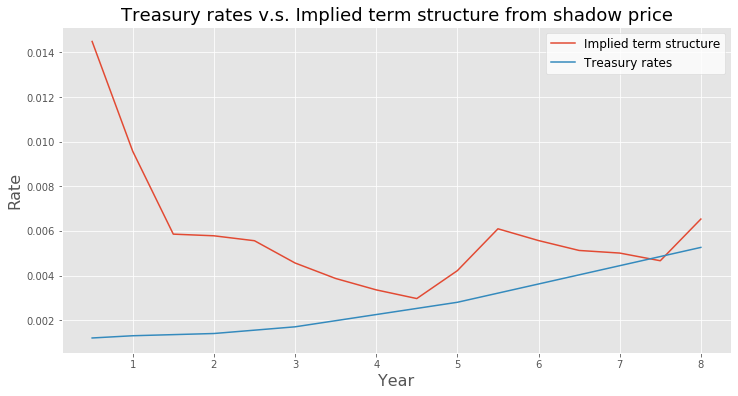

In [13]:
print(' ')
plt.figure(figsize=[12,6])
pd.Series(impliedrates, index=0.5 * np.array(range(1, 17)), name='Implied term structure').plot()
pd.Series(term_struct_interp(np.array(range(1,17)) * 0.5), index=0.5 * np.array(range(1, 17)), name='Treasury rates').plot()
plt.title("Treasury rates v.s. Implied term structure from shadow price", size=18)
plt.legend(fontsize=12, facecolor='white')
plt.ylabel('Rate', size=16)
plt.xlabel('Year', size=16)
plt.show()